# LSTM(Long Short-Term Memory) 

uses 74 features to predict the Q avg to Q avg percentage price change. 


This LSTM model uses:
-	the Adam Optimizer
-	relu activation
-	0.001 learning rate for the Adam Optimizer
-	20 epochs were used
# Import Required Libraries
Import the necessary libraries, including TensorFlow, NumPy, and Pandas.

Run this command to install necessary libraries:

```bash
pip install numpy pandas requests scikit-learn tensorflow matplotlib


In [1]:
# Import Required Libraries
import tensorflow as tf
import numpy as np
import pandas as pd

2024-12-05 23:03:41.436347: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1733457821.552149  293664 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1733457821.579993  293664 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-12-05 23:03:41.826044: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


# Load and Preprocess Data
Load the stock price data, preprocess it by normalizing and creating sequences for training.

In [2]:
from venv import create
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler

# Load the stock price data
data = pd.read_csv('../data/merged_scaled_data.csv')
target = "Q avg to Q avg Price % Change"
# Normalize the data
new_data = data[["Period Ending",target]]
#drop nan values
#having the nan values in the rows affect the traiing as the loss can not be calcluated
#so we drop the rows with nan values
new_data = new_data.dropna()
data = data.dropna()
# Create sequences for training
def create_sequences(data, seq_length, target_column,exclude_columns=None):
    """
    Creates sequences of data for LSTM training.

    Args:
        data (pd.DataFrame): The dataframe containing features and target.
        seq_length (int): The number of timesteps in each sequence.
        target_column (str): The name of the target column.
        exclude_columns (list, optional): List of column names to exclude from features.

    Returns:
        np.array: Array of feature sequences.
        np.array: Array of target values.
    """
    x = []
    y = []
    for i in range(len(data) - seq_length):
        # Define the start and end indices for the sequence
        start_idx = i
        end_idx = i + seq_length

        # Select the sequence slice
        seq_slice = data.iloc[start_idx:end_idx]

        # Exclude specified columns and the target column
        if exclude_columns:
            feature_seq = seq_slice.drop(columns=exclude_columns).values
        else:
            feature_seq = seq_slice.drop(columns=[target_column]).values

        x.append(feature_seq)

        # Select the target value following the sequence
        target_val = data.iloc[end_idx][target_column]
        y.append(target_val)

    return np.array(x), np.array(y)
def create_sequences2(data, seq_length):
    x = []
    y = []
    if len(data) <= seq_length:
        raise ValueError("The length of features must be greater than the sequence length.")
    for i in range(len(data) - seq_length):
        x.append(data[i:i+seq_length])
        y.append(data[i+seq_length])
    return np.array(x), np.array(y)
seq_length = 60
columns_to_drop = ['Ticker Symbol', 'Period Ending', 'Sector', 'For Year', 'Next Qtr. Avg. Price', 'Y avg to Y avg Price % Change', 'Up or Down Q over Q', 'Up or Down Y over Y', 'Buy, Hold, or Sell']
data = data.drop(columns=columns_to_drop)
x, y = create_sequences(data, seq_length,target)
# x, y = create_sequences2(new_data, seq_length)

# Split the data into training and validation sets
split = int(0.8 * len(x))
x_train, x_val = x[:split], x[split:]
y_train, y_val = y[:split], y[split:]



In [3]:

# Check for NaN or Inf values
def check_nan_inf(array, name):
    print(f"\nChecking {name}:")
    print(f"Number of NaNs: {np.isnan(array).sum()}")
    print(f"Number of Infs: {np.isinf(array).sum()}")
print(x_train.dtype)  # Should be float32 or float64
print(y_train.dtype)  # Should be float32 or float64
print(x_val.dtype)
print(y_val.dtype)
print(x_train.shape)  # Should be (num_samples, seq_length, num_features)
check_nan_inf(x_train, "x_train")
check_nan_inf(y_train, "y_train")
check_nan_inf(x_val, "x_val")
check_nan_inf(y_val, "y_val")

float64
float64
float64
float64
(983, 60, 75)

Checking x_train:
Number of NaNs: 0
Number of Infs: 0

Checking y_train:
Number of NaNs: 0
Number of Infs: 0

Checking x_val:
Number of NaNs: 0
Number of Infs: 0

Checking y_val:
Number of NaNs: 0
Number of Infs: 0


# Build the LSTM Model
Define the LSTM model architecture using TensorFlow's Keras API.

In [4]:
# Build the LSTM Model
units = 25
num_features = x_train.shape[2]
print(x_train.shape[1])
activation = 'relu'
model = tf.keras.Sequential([
    tf.keras.layers.LSTM(units=units, return_sequences=True, input_shape=(None, num_features)),
    tf.keras.layers.LSTM(units=units),
    tf.keras.layers.Dense(1,activation=activation)
])

model.compile(optimizer='adam', loss='mean_squared_error')
model.summary()
# Train the model
print(x_train.shape)
print(y_train.shape)
print(x_val.shape)
print(y_val.shape)
history = model.fit(
    x_train, 
    y_train, 
    epochs=20, 
    batch_size=64, 
    validation_data=(x_val, y_val))

# Evaluate the model
loss = model.evaluate(x_val, y_val)
print(f'Validation Loss: {loss}')

60


2024-12-05 23:03:56.864477: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:152] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)
/home/aishwaryapb/.pyenv/versions/3.11.10/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, None, 25)       │        10,100 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 25)             │         5,100 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │            26 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 15,226 (59.48 KB)

 Trainable params: 15,226 (59.48 KB)

 Non-trainable params: 0 (0.00 B)

(983, 60, 75)
(983,)
(246, 60, 75)
(246,)
Epoch 1/20


2024-12-05 23:03:57.197540: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 17694000 exceeds 10% of free system memory.


16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 92ms/step - loss: 109.9346 - val_loss: 118.2871
Epoch 2/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 47ms/step - loss: 91.4801 - val_loss: 115.7078
Epoch 3/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step - loss: 88.9326 - val_loss: 115.9315
Epoch 4/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 45ms/step - loss: 102.4713 - val_loss: 116.1977
Epoch 5/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step - loss: 101.3666 - val_loss: 116.3244
Epoch 6/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 43ms/step - loss: 94.7869 - val_loss: 116.2568
Epoch 7/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 43ms/step - loss: 100.0298 - val_loss: 116.3640
Epoch 8/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 43ms/step - loss: 92.6834 - val_loss: 116.3254
Epoch 9/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 49ms/step - loss: 93.1025 - val_loss: 116.3933
Epoch 10/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 47ms/step - loss: 95.4639 - val_loss: 116.3798
Epoch 11/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 45ms/step - loss: 88.0812 - val_loss: 116.7126
Epoch 12/20
16/16 ━━━━━━━━━━━━━━━━━━━

# Evaluate the Model
Evaluate the model's performance on a test dataset.

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 114.7626
Validation Loss: 117.19043731689453
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 48ms/step
Mean Squared Error: 117.19043222619504
Root Mean Squared Error: 10.825452980184942
R^2 Score: -0.021534214869062707
Average Difference: 8.12113827736397
Actual Values Mean: 3.1289430894308947
Max Prediction: 5.653998851776123
Min Prediction: 0.0


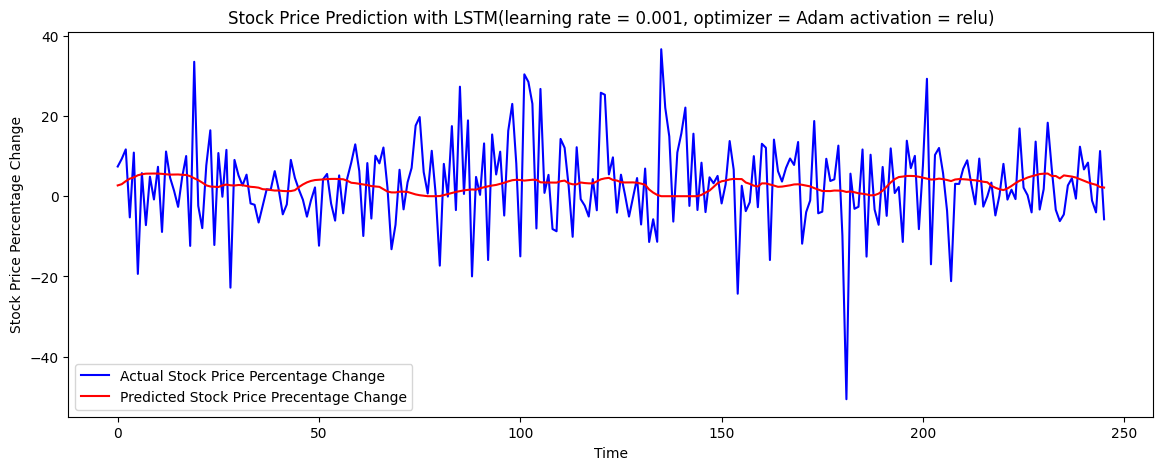

In [5]:
# Evaluate the Model
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
# Evaluate the model's performance on the test dataset
loss = model.evaluate(x_val, y_val)
print(f'Validation Loss: {loss}')

# Make predictions on the validation set
predictions = model.predict(x_val)

# Inverse transform the predictions and actual values to get the original scale
actual = y_val.reshape(-1, 1)
mse_val = mean_squared_error(actual, predictions)
print(f'Mean Squared Error: {mse_val}')
root_mse_val = np.sqrt(mse_val)
print(f'Root Mean Squared Error: {root_mse_val}')
# had used r2 score before but for time series data it is not really that good for evaluation because idata in time series exhibits autocorrelation
r2 = r2_score(actual, predictions)
print(f'R^2 Score: {r2}')
##### calculuating the average differences between actual and predicted values
diff = np.abs(actual - predictions)
avg_diff = np.mean(diff)
print(f'Average Difference: {avg_diff}')
# print the actual values mean
print(f'Actual Values Mean: {np.mean(actual)}')

#printing the max and min prediction
print(f'Max Prediction: {np.max(predictions)}')
print(f'Min Prediction: {np.min(predictions)}')

# Plot the predictions against the actual values
import matplotlib.pyplot as plt

plt.figure(figsize=(14, 5))
plt.plot(actual, color='blue', label='Actual Stock Price Percentage Change')
plt.plot(predictions, color='red', label='Predicted Stock Price Precentage Change')
title = f'Stock Price Prediction with LSTM(learning rate = {"0.001"}, optimizer = {"Adam"} activation = {activation})'
plt.title(title)
# time is the 250 differnt time stamps from 2012- 2016
plt.xlabel('Time')
plt.ylabel('Stock Price Percentage Change')
plt.legend()
plt.show()